In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Using cuda for inference


In [26]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

0

In [27]:
resneXt = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resneXt')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resneXt.eval().to(device)

Using cache found in C:\Users\adity/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\adity/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [28]:
import torch.nn as nn

for param in resneXt.parameters():
    param.requires_grad = False #This does the freezing in the model (You freeze the weights and only use the last layer!)

num_features = resneXt.fc.in_features
resneXt.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048, 128),nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 7))
resneXt.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [52]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

data = pd.read_csv('HAM10000_metadata_paths.csv')
mapping = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'bcc': 4, 'akiec': 5, 'vasc': 6}
X = data['image_path']
y = data['dx'].map(mapping)
print(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


class HAM(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

train_dataset = HAM(X_train, y_train, transform=transform)
val_dataset = HAM(X_val, y_val, transform=transform)
test_dataset = HAM(X_test, y_test, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

0        0
1        0
2        0
3        0
4        0
        ..
10010    5
10011    5
10012    5
10013    5
10014    3
Name: dx, Length: 10015, dtype: int64


In [53]:
optimizer = torch.optim.Adam(resneXt.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda'
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
loss_fn = nn.CrossEntropyLoss()

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device='cuda'):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs
            labels = labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs
                labels = labels
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # torch.save(model.state_dict(), 'cnn_model.pth')
    torch.save(model, 'resneXt_model.pkl')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [54]:
train_losses, train_accuracies, val_losses, val_accuracies = train(resneXt, optimizer, loss_fn, train_loader, val_loader, epochs=50, device='cuda')
print(f'Training Losses: {train_losses}')
print(f'Training Accuracies: {train_accuracies}')
print(f'Validation Losses: {val_losses}')
print(f'Validation Accuracies: {val_accuracies}')

Epoch 1: Train Loss: 0.5046, Train Accuracy: 0.8186, Val Loss: 0.6119, Val Accuracy: 0.8022
Epoch 2: Train Loss: 0.4781, Train Accuracy: 0.8249, Val Loss: 0.6051, Val Accuracy: 0.8002
Epoch 3: Train Loss: 0.4676, Train Accuracy: 0.8264, Val Loss: 0.5866, Val Accuracy: 0.8072
Epoch 4: Train Loss: 0.4472, Train Accuracy: 0.8320, Val Loss: 0.5925, Val Accuracy: 0.8032
Epoch 5: Train Loss: 0.4346, Train Accuracy: 0.8369, Val Loss: 0.6060, Val Accuracy: 0.8042
Epoch 6: Train Loss: 0.4310, Train Accuracy: 0.8421, Val Loss: 0.5953, Val Accuracy: 0.8002
Epoch 7: Train Loss: 0.4112, Train Accuracy: 0.8470, Val Loss: 0.6007, Val Accuracy: 0.8072
Epoch 8: Train Loss: 0.4083, Train Accuracy: 0.8480, Val Loss: 0.6066, Val Accuracy: 0.8122
Epoch 9: Train Loss: 0.3997, Train Accuracy: 0.8482, Val Loss: 0.5950, Val Accuracy: 0.8142
Epoch 10: Train Loss: 0.3920, Train Accuracy: 0.8517, Val Loss: 0.5970, Val Accuracy: 0.8082
Epoch 11: Train Loss: 0.3820, Train Accuracy: 0.8550, Val Loss: 0.5937, Val Acc

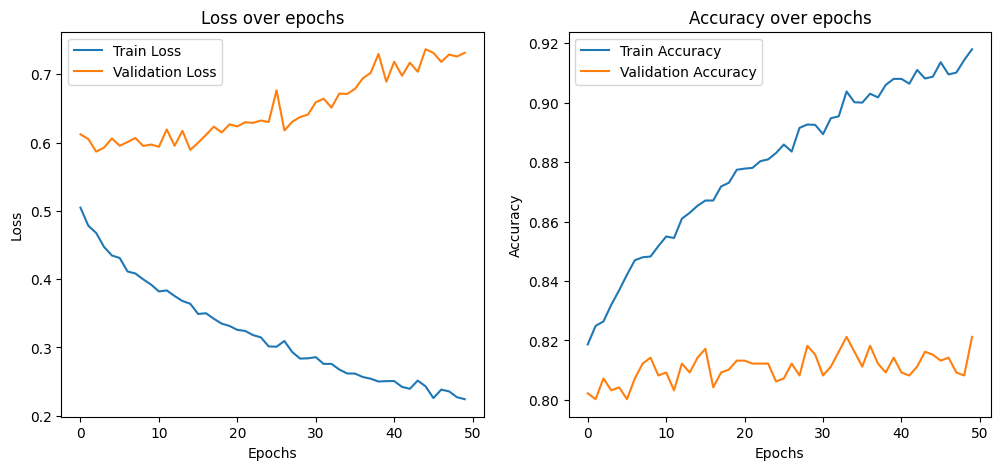

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
test_loss, test_correct = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resneXt(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.7029, Test Accuracy: 0.7974
